In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as rmse, r2_score as r2

In [2]:
df = pd.read_csv(r"prepared_dataset")
df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,delivery_duration_min,is_weekend,hour,avg_item_price,...,month_January,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,4,34.41,4,5.57,12.39,21.0,62.98,0,22,8.60,...,0,0,0,0,0,0,0,0,0,1
1,1,19.00,1,19.00,19.00,0.0,29.68,0,20,19.00,...,1,0,0,0,1,0,0,1,0,0
2,6,69.00,5,6.00,18.00,2.0,51.25,0,21,11.50,...,0,0,0,0,0,1,0,0,0,1
3,3,39.00,3,11.00,16.00,9.0,39.83,1,2,13.00,...,0,0,0,1,0,0,0,0,0,1
4,3,50.00,3,15.00,19.00,2.0,38.33,0,20,16.67,...,1,0,0,0,0,0,1,1,0,0


## Models Building

### Splitting dataset

In [23]:
X = df.drop("delivery_duration_min", axis=1)
y = df["delivery_duration_min"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [24]:
# scaling dataset
scaler = StandardScaler().fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# hyperparameters
alpha_values = 10 ** np.linspace(-3, 3, 200)
l1_ratios = np.linspace(0.01, 1, 20)

### Fitting models

In [5]:
linear_regression = LinearRegression().fit(X_train, y_train)
lasso_model = LassoCV(alphas=alpha_values, cv=5).fit(X_train_scale, y_train)
ridge_model = RidgeCV(alphas=alpha_values, cv=5).fit(X_train_scale, y_train)
enet_model = ElasticNetCV(alphas=alpha_values, l1_ratio=l1_ratios, cv=5).fit(X_train_scale, y_train)

In [25]:
# function to estimate key metrics for models

def model_performance(model, X, y):
    r2_score = r2(y, model.predict(X)).round(3)
    mae_score = mae(y, model.predict(X)).round(3)
    rmse_score = rmse(y, model.predict(X), squared=False).round(3)
    
    values = [r2_score, mae_score, rmse_score]
    return pd.Series(values, index=["R2", "MAE", "RMSE"])

### Training results

In [26]:
training_results = pd.DataFrame(index=["R2", "MAE", "RMSE"])

for i, model in enumerate([linear_regression, lasso_model, ridge_model, enet_model]):
    if i > 0: data = model_performance(model, X_train_scale, y_train).to_frame(i)
    else: data = model_performance(model, X_train, y_train).to_frame(i)
    training_results = pd.concat([training_results, data], axis=1)

training_results.rename(columns={0: "linear_regression", 1: "lasso", 2: "ridge", 3: "enet"})

,linear_regression,lasso,ridge,enet
R2,0.954,0.954,0.954,0.954
MAE,2.980,2.980,2.980,2.980
RMSE,3.656,3.657,3.656,3.657


### Residual plot + Q-Q plot for linear regression

In [59]:
# function to display Residual plot + Q-Q plot
def plots(predictions, y):
	residuals = y - predictions
	fig, ax = plt.subplots(1, 2, sharey="all", figsize=(12, 6))

	sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
	ax[0].set_title("Residual Plot")
	ax[0].set_xlabel("Prediction")
	ax[0].set_ylabel("Residuals")

	stats.probplot(residuals, dist="norm", plot=ax[1])
	ax[1].set_title("Normal Q-Q Plot")

	plt.show();

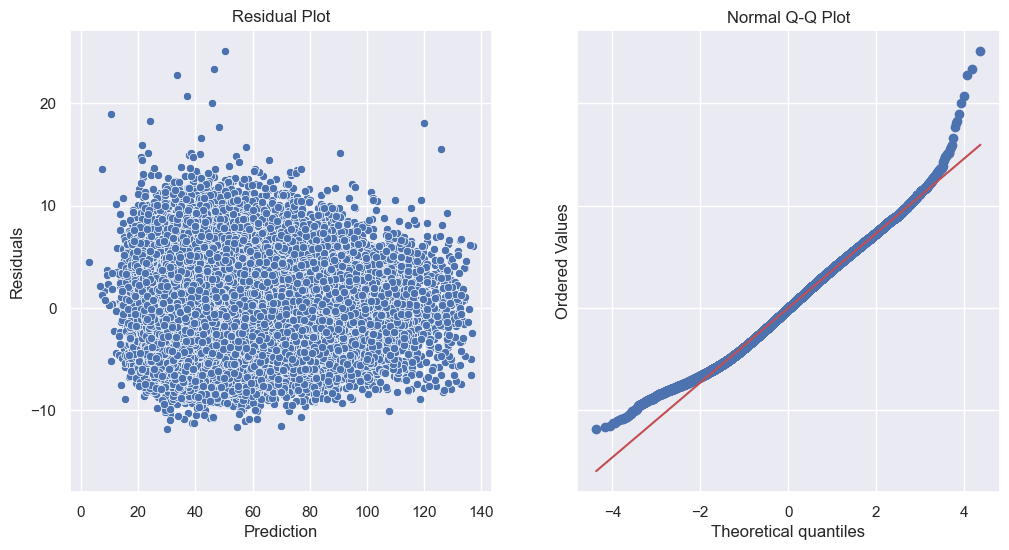

In [60]:
plots(linear_regression.predict(X_train), y_train)

In [28]:
# Identify columns with the less impact (zeros)
[x for x in list(zip(X.columns, lasso_model.coef_)) if x[1] == 0]

[('available_couriers_10_miles', -0.0),
 ('store_primary_category_african', -0.0),
 ('store_primary_category_cheese', 0.0),
 ('store_primary_category_chocolate', -0.0),
 ('store_primary_category_dim-sum', -0.0),
 ('store_primary_category_gluten-free', -0.0),
 ('store_primary_category_japanese', -0.0),
 ('store_primary_category_kosher', 0.0),
 ('store_primary_category_lebanese', -0.0),
 ('store_primary_category_none', -0.0),
 ('store_primary_category_peruvian', -0.0),
 ('store_primary_category_thai', -0.0),
 ('day_Saturday', 0.0),
 ('time_of_day_Evening', 0.0)]

### Evaluating performance

In [29]:
test_results = pd.DataFrame(index=["R2", "MAE", "RMSE"])

for i, model in enumerate([linear_regression, lasso_model, ridge_model, enet_model]):
	if i > 0: data = model_performance(model, X_test_scale, y_test).to_frame(i)
	else: data = model_performance(model, X_test, y_test).to_frame(i)
	test_results = pd.concat([test_results, data], axis=1)

test_results.rename(columns={0: "linear_regression", 1: "lasso", 2: "ridge", 3: "enet"})

,linear_regression,lasso,ridge,enet
R2,0.954,0.954,0.954,0.954
MAE,2.993,2.993,2.993,2.993
RMSE,3.673,3.673,3.673,3.673


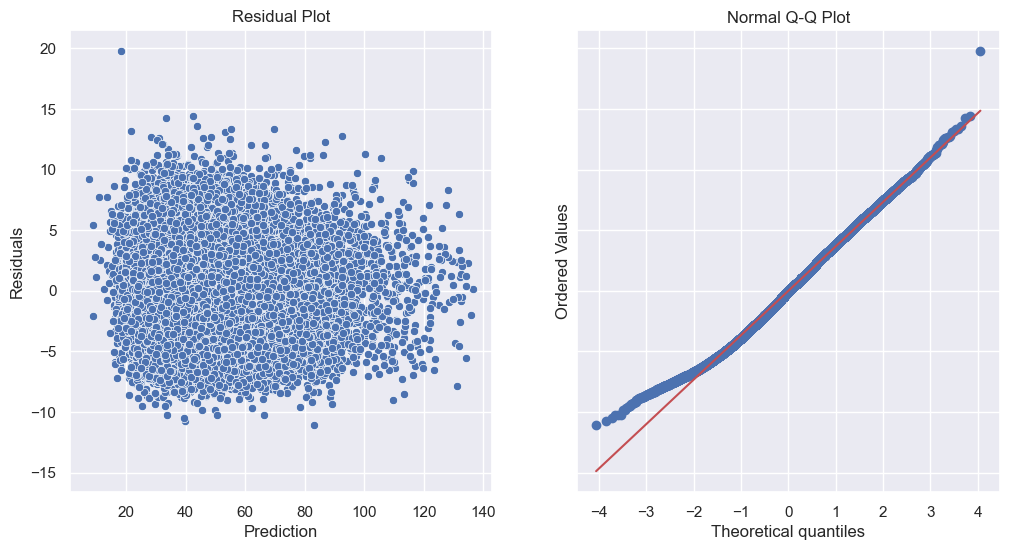

In [61]:
# Plots for test results
plots(linear_regression.predict(X_test), y_test)

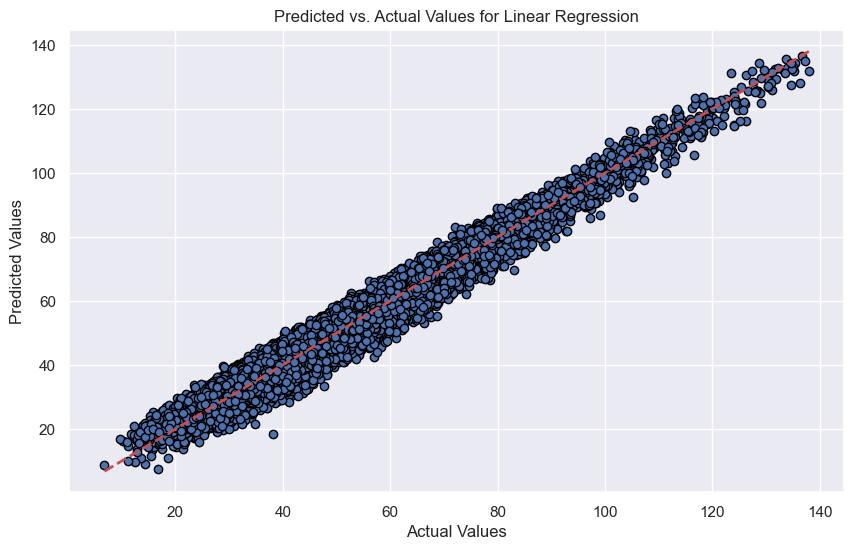

In [62]:
y_pred = linear_regression.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values for Linear Regression")
plt.show();

### Final model

In [32]:
scaler = StandardScaler().fit(X)
X_scale = scaler.transform(X)

final_model = ElasticNetCV(alphas=alpha_values, l1_ratio=l1_ratios, cv=5).fit(X, y)
model_performance(final_model, X, y).to_frame("values")

,values
R2,0.954
MAE,2.984
RMSE,3.661
